# Extract Data from yfinance

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import datetime

warnings.filterwarnings('ignore')

df = yf.download('TSLA', 
                  start='2019-01-01', 
                  end='2024-4-29', 
                  progress=False)
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-22,140.559998,144.440002,138.800003,142.050003,142.050003,107097600
2024-04-23,143.330002,147.259995,141.110001,144.679993,144.679993,124545100
2024-04-24,162.839996,167.970001,157.509995,162.130005,162.130005,181178000
2024-04-25,158.960007,170.880005,158.360001,170.179993,170.179993,126427500
2024-04-26,168.850006,172.119995,166.369995,168.289993,168.289993,109815700


In [2]:
df['Date'] = df.index  # Create a new column 'Date' with the index values
df.reset_index(drop=True, inplace=True) 

In [3]:
close_df = df[['Date', 'Close']]

In [4]:
close_df = close_df.set_index('Date')

In [5]:
#close_df = close_df.drop('Date', axis = 1)

In [6]:
close_df.head()

,Close
Date,
2019-01-02,20.674667
2019-01-03,20.024000
2019-01-04,21.179333
2019-01-07,22.330667
2019-01-08,22.356667


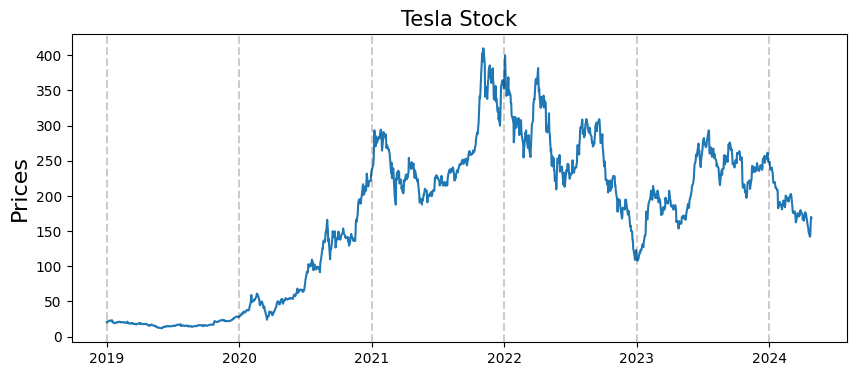

In [7]:
start_date = datetime(2019,1,1)
end_date = datetime(2025,1,1)

plt.figure(figsize=(10,4))
plt.plot(close_df)
plt.title('Tesla Stock', fontsize=15)
plt.ylabel('Prices', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

# Plotting ACF and PACF before differncing

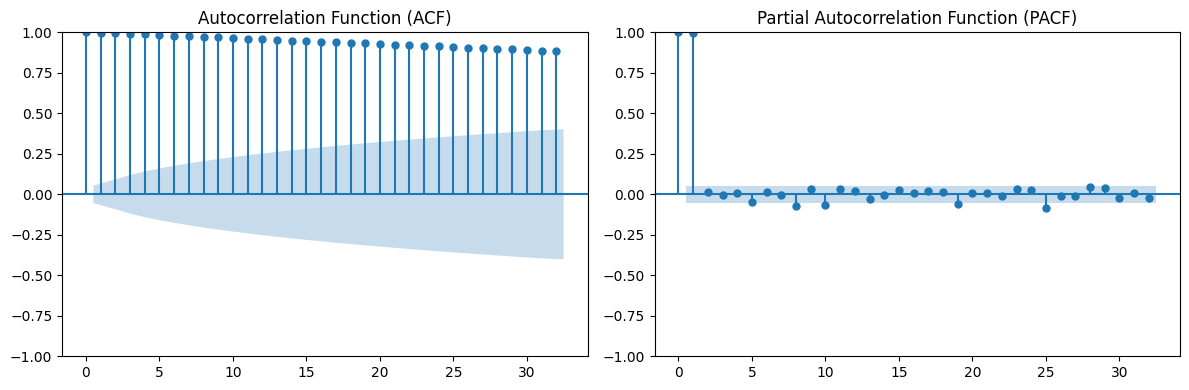

In [8]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4))

plot_acf(close_df, axes[0])
plot_pacf(close_df, axes[1])

axes[0].set_title('Autocorrelation Function (ACF)')
axes[1].set_title('Partial Autocorrelation Function (PACF)')


plt.tight_layout()

plt.show()

The ACF showing many lags close to 1 suggests the presence of a trend or non-stationarity in the data, while the PACF showing lag 1 as significant indicates the presence of autocorrelation. Before proceeding with differencing the data, using the Ljung-Box test is a good idea. The Ljung-Box test can help determine whether the autocorrelation observed in the data is statistically significant or if it can be attributed to randomness or white noise.

# Ljung-Box test

Null Hypothesis (H0): There is no autocorrelation in the time series data beyond the specified lag(s). \
Alternative Hypothesis (H1): There is autocorrelation in the time series data beyond the specified lag(s).

In [9]:
lb_test = sm.stats.acorr_ljungbox(close_df, lags=1, return_df=True)
lb_test

,lb_stat,lb_pvalue
1,1333.019437,7.545772e-292


Since the p-value is less than 0.05, we reject the null hypothesis. This implies that our data exhibits autocorrelation

# Stationary

In [10]:
adf_test = adfuller(close_df)
if adf_test[1] < 0.05:
    print('Stationary, {}'.format(adf_test[1]))
else:
    print('Need to do more differencing, {}'.format(adf_test[1]))

Need to do more differencing, 0.37260239243866167


# Apply First Differencing

In [11]:
close_df_diff = close_df.diff().dropna()

In [12]:
adf_test = adfuller(close_df_diff)
if adf_test[1] < 0.05:
    print('Stationary, {}'.format(adf_test[1]))
else:
    print('Need to do more differencing, {}'.format(adf_test[1]))

Stationary, 8.813774194118052e-10


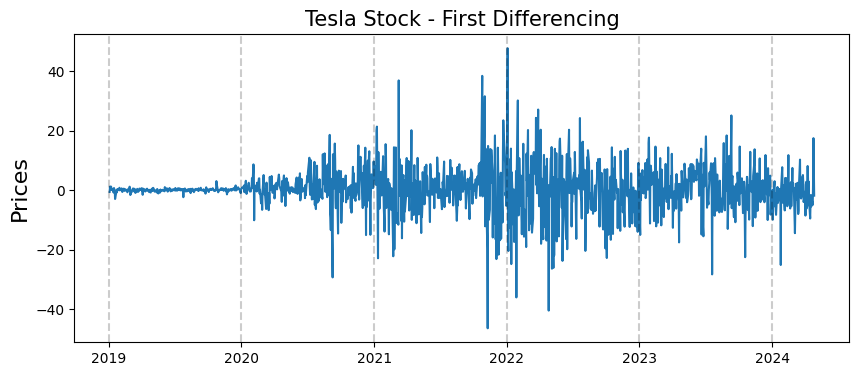

In [13]:
plt.figure(figsize=(10,4))
plt.plot(close_df_diff)
plt.title('Tesla Stock - First Differencing', fontsize=15)
plt.ylabel('Prices', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

# Plotting ACF and PACF after differncing

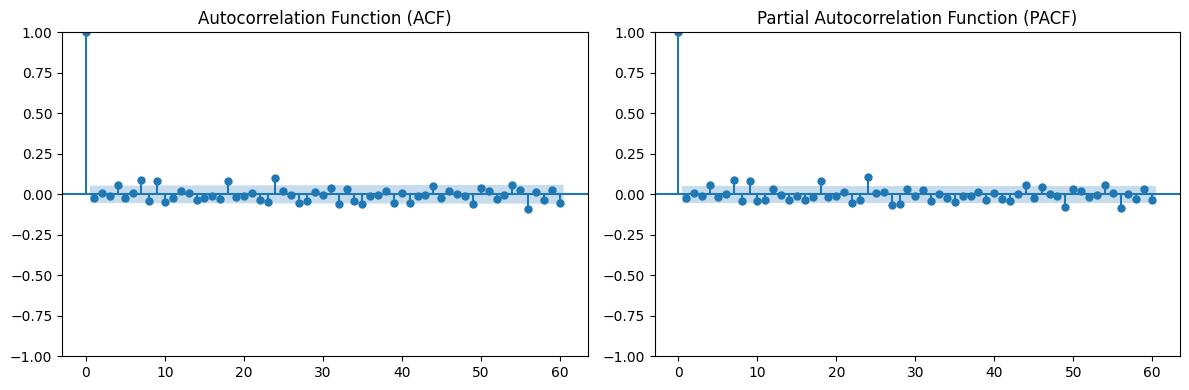

In [14]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4))

plot_acf(close_df_diff, lags = 60, ax = axes[0])
plot_pacf(close_df_diff, lags = 60, ax = axes[1])

axes[0].set_title('Autocorrelation Function (ACF)')
axes[1].set_title('Partial Autocorrelation Function (PACF)')


plt.tight_layout()

plt.show()

The best AR p and q value from PACF and ACF are (7,9,18,24)

# Split Data

In [15]:
train_size = int(len(close_df) * 0.80)  
train = close_df[:train_size]
test = close_df[train_size:]

In [16]:
print(train.shape, test.shape)

(1071, 1) (268, 1)


In [17]:
import pmdarima as pm
model = pm.auto_arima(close_df, start_p=1, d= 1, max_p=30, maxiter=50)
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1339
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -4604.674
Date:                Thu, 09 May 2024   AIC                           9211.348
Time:                        16:02:38   BIC                           9216.547
Sample:                             0   HQIC                          9213.296
                               - 1339                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        57.1149      1.152     49.569      0.000      54.857      59.373
Ljung-Box (L1) (Q):                   0.79   Jarque-Bera (JB):              1604.59
Prob(Q):                              0.38   Pr

In [18]:
history = list(train.values)
pred = []

In [19]:
history[-1]

array([194.77000427])

In [20]:
test.values[0]

array([192.58000183])

# Before applying Rolling Forecast

In [21]:
model1 = ARIMA(history, order = (7,1,0))
model_fit1 = model1.fit()

In [22]:
pred1 = []
outputs = model_fit1.forecast(steps= len(test))
pred1.append(outputs)

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
    
def calculate_mape(actual, forecast):
    
    if len(actual) != len(forecast):
        raise ValueError("Length of actual and forecast lists must be the same")
    
    absolute_errors = [abs(actual[i] - forecast[i]) for i in range(len(actual))]
    percentage_errors = [absolute_errors[i] / actual[i] * 100 for i in range(len(actual))]
    mape = sum(percentage_errors) / len(actual)
    
    return mape
def metrics(test, pred):
    mae = mean_absolute_error(test.values, pred)
    RMSE = rmse(test.values, pred)
    MAPE =  calculate_mape(test.values, pred)
    r2 = r2_score(test.values, pred)
    return mae, RMSE, MAPE, r2

In [24]:
mae, RMSE, MAPE, r2 = metrics(test, pred1[0])
print("MAE:", mae)
print("RMSE", RMSE)
print("MAPE", MAPE[0])
print("R2", r2)

MAE: 37.48074645878836
RMSE 43.85368006601605
MAPE 16.38331175409463
R2 -0.36189705107113457


In [25]:
test_results = pd.DataFrame(data={'Test Predictions':pred1[0], 'Actuals':test['Close'].iloc[-268:]})

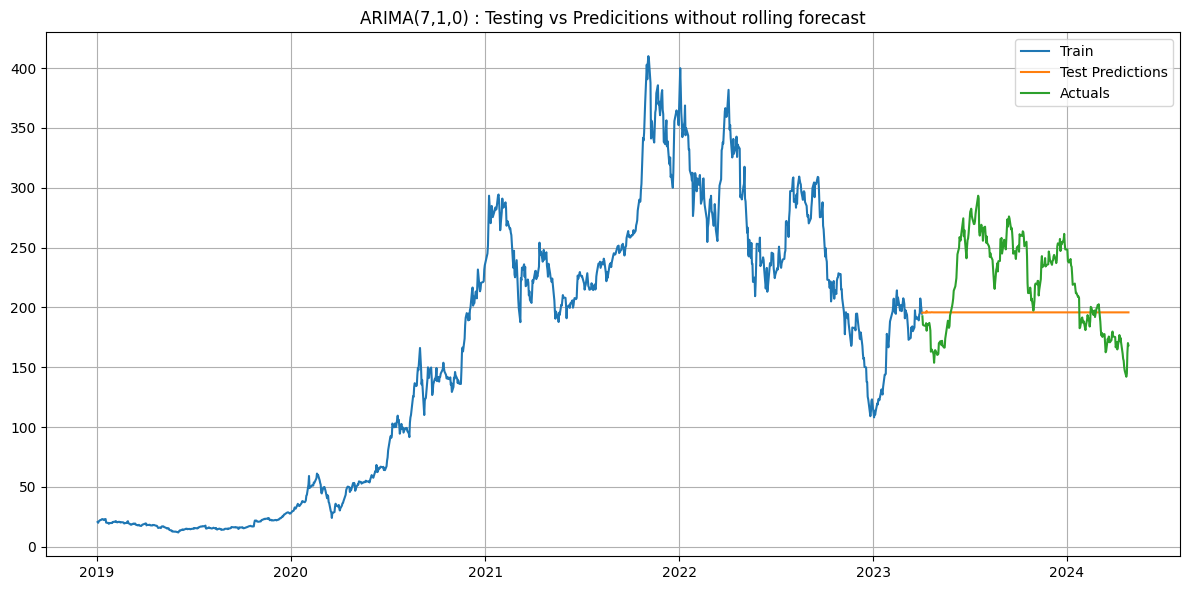

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(train['Close'], label = 'Train')
plt.plot(test_results['Test Predictions'], label = 'Test Predictions')
plt.plot(test_results['Actuals'], label = 'Actuals')
plt.title('ARIMA(7,1,0) : Testing vs Predicitions without rolling forecast')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

# Rolling Forecast

In [27]:
from tqdm import tqdm

progress_bar = tqdm(total=len(test.values))
p_list = [7, 9, 18, 24]
mae_lst = []
RMSE_lst = []
MAPE_lst = []
r2_lst = []

pred_all = []
for p in p_list:
    pred = []  
    history = list(train.values)
    progress_bar = tqdm(total=len(test))
    for t in range(len(test)):
        model = ARIMA(history, order=(p, 1, 0))
        model_fit = model.fit()
        output = model_fit.forecast()
        pred.append(output[0])
        history.append(test.values[t])
        
        progress_bar.update(1)
        progress_bar.set_description(f"Percentage completed for AR-{p}: {np.round((t + 1) / len(test) * 100)}%")
    progress_bar.close() 
    
    pred_all.append(pred)  
    
    mae, RMSE, MAPE, r2 = metrics(test[-256:], pred[-256:])
    mae_lst.append(mae)
    RMSE_lst.append(RMSE)
    MAPE_lst.append(MAPE)
    r2_lst.append(r2)
    print("MAE:", mae)
    print("RMSE", RMSE)
    print("MAPE", MAPE[0])
    print("R2", r2)


  0%|                                                                                          | 0/268 [00:00<?, ?it/s]

Percentage completed for AR-7: 100.0%: 100%|█████████████████████████████████████████| 268/268 [01:06<00:00,  4.00it/s]


MAE: 4.987147030757969
RMSE 6.742053664996818
MAPE 2.288941921405057
R2 0.9678940912060245


Percentage completed for AR-9: 100.0%: 100%|█████████████████████████████████████████| 268/268 [01:31<00:00,  2.92it/s]


MAE: 5.032331349270687
RMSE 6.7649387687363
MAPE 2.311626085308446
R2 0.9676757618672338


Percentage completed for AR-18: 100.0%: 100%|████████████████████████████████████████| 268/268 [04:58<00:00,  1.11s/it]


MAE: 5.136190932188976
RMSE 6.8585258601602535
MAPE 2.3583571100884413
R2 0.9667752196523903


Percentage completed for AR-24: 100.0%: 100%|████████████████████████████████████████| 268/268 [09:13<00:00,  2.07s/it]

MAE: 5.234345572058814
RMSE 6.938150934139248
MAPE 2.4031198328424077
R2 0.9659992854477548


In [28]:
MAPE_lst

[array([2.28894192]),
 array([2.31162609]),
 array([2.35835711]),
 array([2.40311983])]

In [29]:
model_df = pd.DataFrame({
    'Model': ['AR(7)', 'AR(9)', 'AR(18)', 'AR(24)'],
    'MAE': [mae_lst[0], mae_lst[1], mae_lst[2], mae_lst[3]],
    'RMSE': [RMSE_lst[0], RMSE_lst[1], RMSE_lst[2], RMSE_lst[3]],
    'MAPE': [MAPE_lst[0][0], MAPE_lst[1][0], MAPE_lst[2][0], MAPE_lst[3][0]]
})
model_df

,Model,MAE,RMSE,MAPE
0,AR(7),4.987147,6.742054,2.288942
1,AR(9),5.032331,6.764939,2.311626
2,AR(18),5.136191,6.858526,2.358357
3,AR(24),5.234346,6.938151,2.403120


In [30]:
#pred_all[0]

In [31]:
#test_ = [x[0] for x in test.values]

In [33]:
test_results = pd.DataFrame(data={'Test Predictions (AR(7))':pred_all[0],'Test Predictions (AR(9))':pred_all[1],
                                  'Test Predictions (AR18))':pred_all[2], 'Test Predictions (AR(24))':pred_all[3],
                                  'Actuals':test['Close'].iloc[-268:]})

In [34]:
test_results

,Test Predictions (AR(7)),Test Predictions (AR(9)),Test Predictions (AR18)),Test Predictions (AR(24)),Actuals
Date,,,,,
2023-04-04,195.515957,194.660619,192.987490,193.073881,192.580002
2023-04-05,192.698259,192.969225,192.388306,190.866915,185.520004
2023-04-06,186.058637,185.804012,186.905503,188.297796,185.059998
2023-04-10,184.719026,184.936515,185.333531,185.474583,184.509995
2023-04-11,184.562867,184.110711,182.899014,182.333467,186.789993
...,...,...,...,...,...
2024-04-22,147.230533,147.802552,148.744095,149.617853,142.050003
2024-04-23,141.780016,141.250569,140.851947,140.741407,144.679993
2024-04-24,143.382309,143.813139,143.711538,144.047132,162.130005


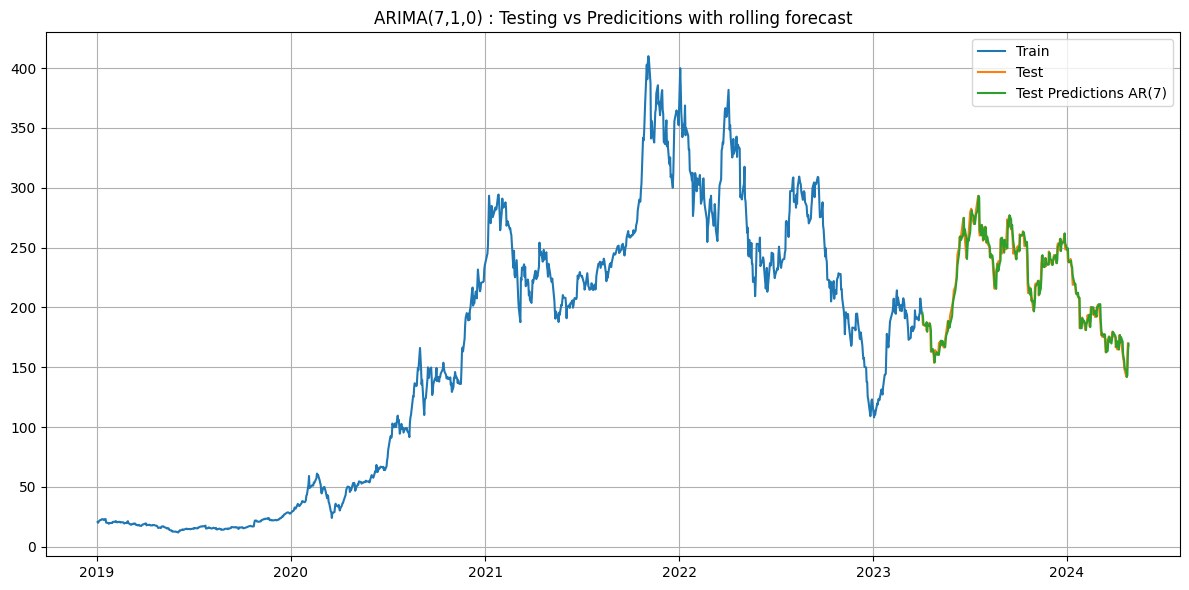

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(train['Close'], label = 'Train')
plt.plot(test_results['Actuals'], label = 'Test')
plt.plot(test_results['Test Predictions (AR(7))'], label = 'Test Predictions AR(7)')
#plt.plot(test_results['Test Predictions (AR(9))'], label = 'Test Predictions AR(9)')
#plt.plot(test_results['Test Predictions (AR18))'], label = 'Test Predictions AR(18)')
#plt.plot(test_results['Test Predictions (AR(24))'], label = 'Test Predictions AR(24)')


plt.title('ARIMA(7,1,0) : Testing vs Predicitions with rolling forecast')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

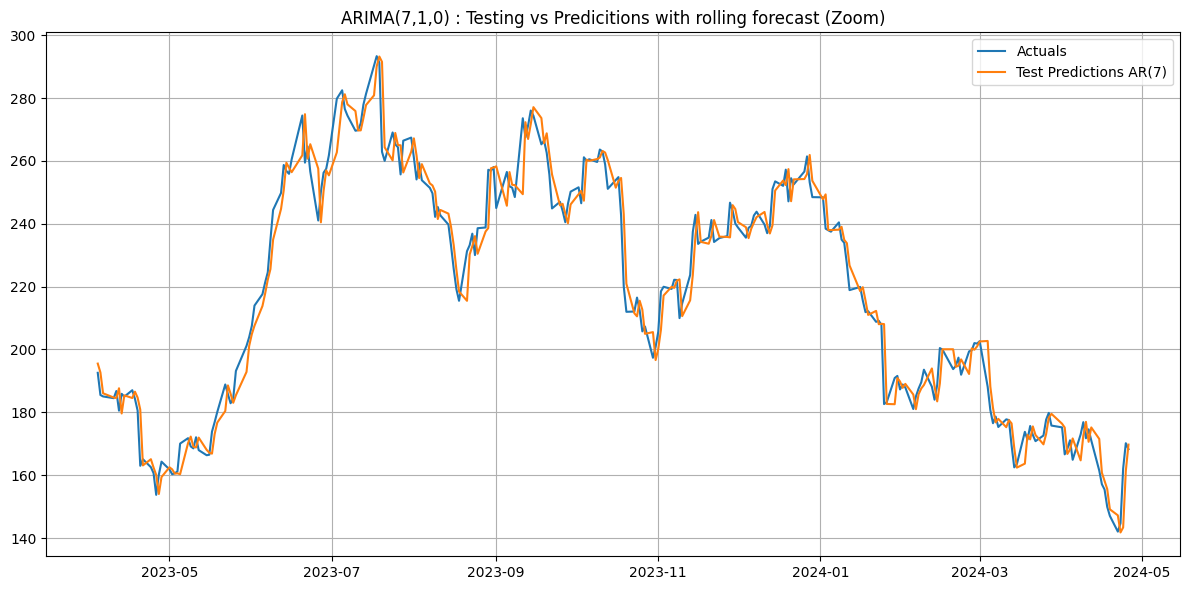

In [36]:
plt.figure(figsize=(12, 6))
#plt.plot(train['Close'], label = 'Train')
plt.plot(test_results['Actuals'], label = 'Actuals')
plt.plot(test_results['Test Predictions (AR(7))'], label = 'Test Predictions AR(7)')
#plt.plot(test_results['Test Predictions (AR(9))'], label = 'Test Predictions AR(9)')
#plt.plot(test_results['Test Predictions (AR18))'], label = 'Test Predictions AR(18)')
#plt.plot(test_results['Test Predictions (AR(24))'], label = 'Test Predictions AR(24)')


plt.title('ARIMA(7,1,0) : Testing vs Predicitions with rolling forecast (Zoom)')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

In [37]:

model = ARIMA(close_df, order=(7, 1, 0))
model_fit = model.fit()
output = model_fit.forecast()
output

1339    167.955452
dtype: float64

# Compare the next predicitions with real data

In [38]:
df = yf.download('TSLA', 
                  start='2024-04-30', 
                  end='2024-05-1', 
                  progress=False)

df['Close'].values[0]

183.27999877929688

In [39]:
print('MSA',np.abs(df['Close'].values[0] - output))

MSA 1339    15.324547
dtype: float64
